In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.optimizers import Optimizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")
 
# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

/home/cse/ug/14075041/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.1
set_session(tf.Session(config=config))

In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4775923330213920301
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 209518592
locality {
  bus_id: 4
}
incarnation: 7254909780015349038
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:c1:00.0"
]


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

u'/gpu:0'

In [5]:
# Declare variables
 
batch_size = 32
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch
 
num_classes = 10 #
epochs = 40 # repeat 10 times

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
# x_train - training data(images), y_train - labels(digits)

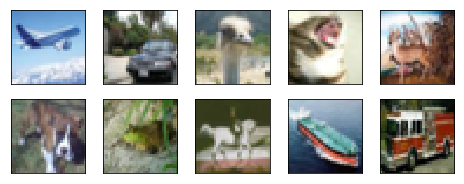

In [7]:
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(1,2,0))
    plt.imshow(im)
plt.show()

In [8]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

 Define Our own Proximal Optimizers 

In [9]:

class PGA(Optimizer):
    """Stochastic gradient descent optimizer.
    Includes support for momentum,
    learning rate decay, and Nesterov momentum.
    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter that accelerates SGD
            in the relevant direction and dampens oscillations.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
    """

    def __init__(self, lr=0.01, momentum=0., decay=0., reg = 0,
                 nesterov=False, **kwargs):
        super(PGA, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.momentum = K.variable(momentum, name='momentum')
            self.decay = K.variable(decay, name='decay')
            self.reg = K.variable(reg,name = 'reg')
        self.initial_decay = decay
        self.nesterov = nesterov
    def prox_l2 (self, v, lmbda):
         return (1.0/(1.0+lmbda))*v
    
    def prox_l1 (self, v, lmbda):
         return np.maximum(0,v-lmbda) - np.maximum(0,-v-lmbda)
    
    
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        reg = self.reg
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))
        
        # momentum
        shapes = [K.int_shape(p) for p in params]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g in zip(params, grads):
            #new_p = p - lr*g
            new_p = self.prox_l2(p -lr*g,lr*reg)
            #new_p[:-1] = self.prox_l1(p[:-1]-lr*g[:-1],lr*reg)
            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov}
        base_config = super(PGA, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [10]:
def base_model(opt):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(Dropout(0.2))

    model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
# Train model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
my_optimizer = PGA(lr = 1e-1 , reg = 1e-3,decay = 1e-6)

In [ ]:
cnn_n = base_model(my_optimizer)
cnn_n.summary()

In [ ]:
from keras_sequential_ascii import sequential_model_to_ascii_printout
sequential_model_to_ascii_printout(cnn_n)

In [ ]:
# Fit model
import cPickle as pickle
cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test),shuffle=True)

with open('pga-h', 'wb') as fp:
    pickle.dump(cnn.history, fp)
scores = cnn_n.evaluate(x_test, y_test, verbose=0)
with open('pga-score', 'wb') as fp:
    pickle.dump(scores, fp)

In [11]:
import cPickle as pickle
cnn_n = base_model('adam')
cnn_n.summary()
cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test),shuffle=True)

with open('adam-h', 'wb') as fp:
    pickle.dump(cnn.history, fp)
scores = cnn_n.evaluate(x_test, y_test, verbose=0)
with open('adam-score', 'wb') as fp:
    pickle.dump(scores, fp)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 16, 16)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 16, 16)        36928     
__________

In [ ]:
with open('pga-h', 'rb') as fp:
    h = pickle.load(fp)


In [ ]:
import cPickle as pickle
fp = open('fista','wb')
fp.flush()
fp.close()
with open('fista','rb') as fp:
     cnn = pickle.load(fp)

In [ ]:
h

In [ ]:
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, 41, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 41, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
 
plt.show()

In [ ]:
scores = cnn_n.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn_n.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
 
for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)
 
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd
 
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()